**Figure 5**, panel B<br>
Testing for the probability of success of introgressed circadian eQTLs in each GTEx tissue using Fisher's exact test.

In [1]:
# --------------------------------------------------------------

In [ ]:
# INPUT DATA
BG_DIR = '../data/gtex_v8_hg19_introgressed.bed.gz'
C_GENES = '../data/circadian_genes.list'
# OUTPUT FILE
OUTPUT_DIR = 'data/enrichment_fishers_introgressed_in_tissue.txt'

In [2]:
import os, sys
import pandas as pd
import numpy as np
import math
import pybedtools
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper")

In [3]:
def intersect_wa_wb(df_a, df_b):
    df_a = df_a.add_suffix('_wa')
    df_b = df_b.add_suffix('_wb')
    a_cols = df_a.columns.values.tolist()
    b_cols = df_b.columns.values.tolist()
    a = pybedtools.BedTool.from_dataframe(df_a)
    b = pybedtools.BedTool.from_dataframe(df_b)
    a_and_b = a.intersect(b, wa=True, wb=True)
    a_and_b_df = pd.read_table(a_and_b.fn, names=a_cols + b_cols)
    return a_and_b_df

def fishers_exact(U,right,down,x,t):
    # Fishers exact test
    a = len(x)
    b = len(right) - a
    c = len(down) - a
    d = (len(U) - (a + b + c))

    #table = [[a, b], [c, d]]
    ar = np.array([[a, b],[c, d]])

    oddsratio, pvalue = stats.fisher_exact(ar)

    # fishers_exact_results = '\nOR: {} \nP-VAL: {} \n{}'.format(oddsratio,pvalue,ar)
    #l.append('{}, {}'.format(oddsratio,pvalue))
    
    return ('{}, {}, {}, {}'.format(t,oddsratio,pvalue,a))


# PLOT
def plot_barplot(x,y,df,loc):
    df.sort_values(by=y,inplace=True)
    plt.figure(figsize = (5,10))
    #sns.color_palette("Set2")
    sns.set(font_scale=1.1)
    sns.set_style("whitegrid")
    g = sns.barplot(x=y, orient = 'h',
                y=x,data=df, 
                color='blue', 
                hue='Bonferroni', 
                dodge=False, 
                edgecolor="black",
                palette = 'PuBu_r')
    plt.xticks(rotation=90);
    plt.legend(title='P-value', loc=loc) # , labels=['Not significant', 'Significant', 'Bonferroni threshold']

    #plt.savefig('plots/fishers_introgressed_in_tissue.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [8]:
# FILES
# Circadian genes
c_genes = pd.read_csv(C_GENES,sep='\t').iloc[:,:1]
bg = pd.read_csv(BG_DIR, sep='\t').iloc[:,[0,1,2,3,-2]].drop_duplicates()

# Y axis set: Introgressed GTEx eQTLss matched to a tissue
bottom_left_0 = bg.iloc[:,[0,1,2,-1]].drop_duplicates().drop_duplicates()
# Background: Unique introgressed eQTLs
background = bg.iloc[:,0:3].drop_duplicates()
# X axis set: Circadian SNPs that are introgressed eQTLs
top_right = pd.merge(bg,c_genes,left_on='gene_id',right_on='GeneID').iloc[:,[0,1,2]].drop_duplicates()

# Create list of tissues
tissues = bottom_left_0['eQTL'].drop_duplicates().values.tolist()

In [9]:
# PERFORM FISHER'S EXACT TEST ON EACH GTEX TISSUE
LIST = []
for i in tissues:
    # Select specific tissue
    bottom_left = bottom_left_0[bottom_left_0['eQTL'].isin([i])].iloc[:, 0:3].drop_duplicates()
    # Find x: SNPs in tissue that are introgressed eQTLs
    x = intersect_wa_wb(top_right,bottom_left).iloc[:, 0:3].drop_duplicates()
    # Fisher's Exact Test
    LIST.append( fishers_exact(background,top_right,bottom_left,x,i) )


In [10]:
# CREATE DATAFRAME FROM LIST
df = pd.DataFrame([n.split(', ') for n in LIST], columns=['Tissue','OR','P-value','Variants'])
# Remove kidney cortex from df
df = df[df['Tissue']!='Kidney_Cortex']
df = df.astype({'Tissue': str, 'OR': float, 'P-value': float, 'Variants': str})
print(df.dtypes)
# CREATE OR LOG COLUMN
df['log10(odds ratio)'] = [math.log10(n) for n in df['OR']]
# ADD VARIANT COUNTS TO TISSUE NAMES
df['Tissues'] = df['Tissue'] + ' (' + df['Variants'] + ')'

Tissue       object
OR          float64
P-value     float64
Variants     object
dtype: object


In [17]:
# PLOTS

In [11]:
# BONFERRONI CORRECTION
def myfunc(cat, pval):
    if pval>0.05:
        cat='>0.05'
    elif pval<=0.05 and pval>bonfe:
        cat='<=0.05'
    elif pval<=bonfe:
        cat=round(bonfe,5)
    return cat

bonfe = 0.05/len(tissues)   # 49 tissues
df['Bonferroni'] = ''
df['Bonferroni'] = df.apply(lambda x: myfunc(x['Bonferroni'], x['P-value']), axis=1)


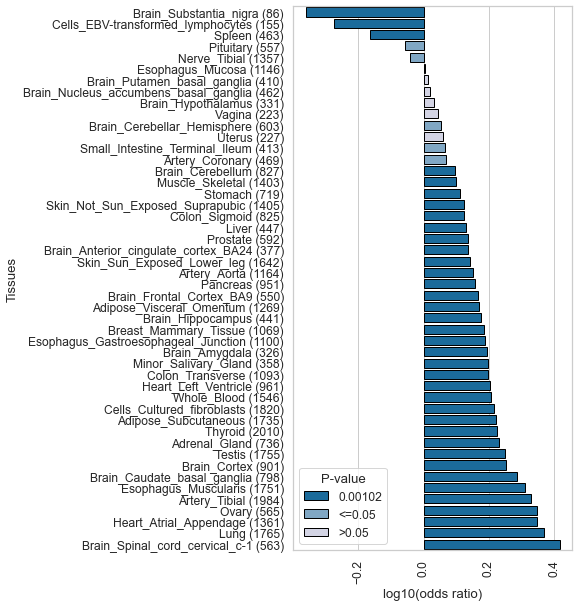

In [12]:
# PLOT FISHER'S LOG10 ODDS RATIO FOR EACH TISSUE
plot_barplot('Tissues','log10(odds ratio)',df,'lower left')

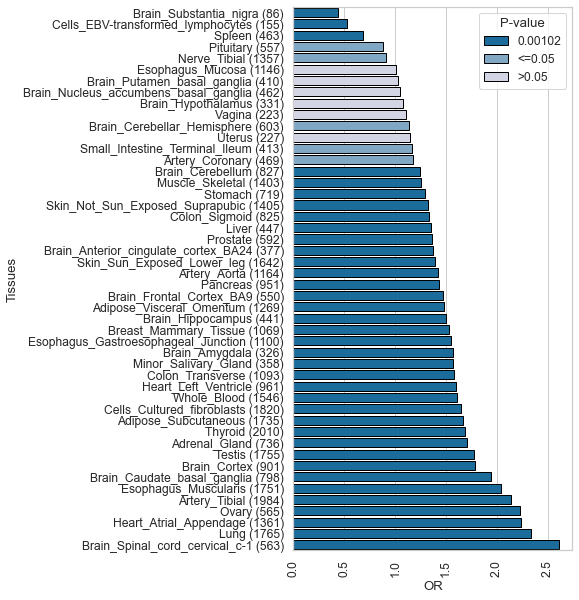

In [13]:
# PLOT OR VALUES
plot_barplot('Tissues','OR',df,'upper right')

In [16]:
print('Introgressed circadian eQTLs are significantly enriched in {} tissues'.format(
        len(df[df['Bonferroni']==0.00102])-3))

Introgressed circadian eQTLs are significantly enriched in 34 tissues
